### 1. Clean raw answers

In [1]:
import pandas as pd
import numpy as np
import re
import os

# List of CSV files to process
csv_files = [
    './10_results.csv', 
    './100_results.csv',
    './1000_results.csv',
]

def clean_raw_answers(file_path):
    """
    Clean raw answers from CSV file, focusing only on extracting digits.
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: DataFrame with raw and cleaned answers
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    def extract_digits(x):
        if pd.isna(x):
            return np.nan
            
        # Convert to string
        x = str(x)
        
        # Remove newline characters and whitespace
        x = x.strip().replace('\n', '')
        
        # If string starts with "user", extract the last number
        if x.startswith('user'):
            numbers = re.findall(r'\d+\.?\d*', x)
            return float(numbers[-1]) if numbers else np.nan
            
        # Extract first number found
        numbers = re.findall(r'\d+\.?\d*', x)
        return float(numbers[0]) if numbers else np.nan
    
    # Create new column with cleaned values
    df['parsed_answers'] = df['raw_answers'].apply(extract_digits)
    
    # Drop rows with NaN in 'cleaned_raw_answers'
    df = df.dropna(subset=['parsed_answers'])

    # Format cleaned values as strings with one decimal point
    df['parsed_answers'] = df['parsed_answers'].apply(lambda x: '{:.1f}'.format(x) if not pd.isna(x) else x)

    return df

# Dictionary to store cleaned DataFrames for each file
cleaned_dataframes = {}

for file_path in csv_files:
    try:
        # Clean the raw answers and store in the dictionary with filename as key
        cleaned_df = clean_raw_answers(file_path)
        filename = os.path.basename(file_path)  # Get the filename (e.g., '10_results.csv')
        cleaned_dataframes[filename] = cleaned_df  # Store the cleaned DataFrame with the filename as key
        
    except Exception as e:
        # Handle any errors (optional: log or pass)
        pass

# Access each cleaned DataFrame by filename
df_10 = cleaned_dataframes.get('10_results.csv')
df_100 = cleaned_dataframes.get('100_results.csv')
df_1000 = cleaned_dataframes.get('1000_results.csv')

"""
# Display or work with each DataFrame separately
df_10.head(10)
df_100.head(10)
df_1000.head(10)

"""

# Get the length of each DataFrame after dropping NaN rows
print (len(df_10))
print (len(df_100))
print (len(df_1000))


825
825
825


### 2. Caculate all metrics for 3 dataframes

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# Assuming df_10, df_100, and df_1000 already exist and have columns `model_name`, `ground_truth`, `parsed_answers`

# Dictionary to store metrics for each dataset
metrics_summary = {}

# List of DataFrames to process
dataframes = {'df_10': df_10, 'df_100': df_100, 'df_1000': df_1000}

# Loop through each dataset
for df_name, df in dataframes.items():
    # Dictionary to store metrics for each model within the current DataFrame
    model_metrics = {}
    
    # Group by `model_name` and calculate metrics for each model within the dataset
    for model_name, data in df.groupby('model_name'):
        # Ensure `ground_truth` and `parsed_answers` columns are numeric, converting non-numeric values to NaN
        data['ground_truth'] = pd.to_numeric(data['ground_truth'], errors='coerce')
        data['parsed_answers'] = pd.to_numeric(data['parsed_answers'], errors='coerce')
        
        # Drop rows where either `ground_truth` or `parsed_answers` is NaN after conversion
        data = data.dropna(subset=['ground_truth', 'parsed_answers'])
        
        # Calculate Mean and Standard Deviation of `parsed_answers`
        mean_parsed_answers = data['parsed_answers'].mean()
        std_parsed_answers = data['parsed_answers'].std()
        
        # Calculate Mean Squared Error (MSE)
        data['mse'] = (data['ground_truth'] - data['parsed_answers']) ** 2
        avg_mse = data['mse'].mean()
        
        # Calculate Mean Log Absolute Error (MLAE)
        data['mlae'] = data.apply(
            lambda row: np.log2(mean_absolute_error([row['ground_truth']], [row['parsed_answers']]) + 0.125),
            axis=1
        )
        
        # Calculate average MLAE and standard deviation of MLAE
        avg_mlae = data['mlae'].mean()
        std_mlae = data['mlae'].std()
        
        # Bootstrap confidence interval for MLAE
        mlae_values = data['mlae'].dropna().values  # Drop NaN values, if any
        bootstrap_result = bs.bootstrap(np.array(mlae_values), stat_func=bs_stats.std)
        confidence_value = 1.96 * bootstrap_result.value  # 95% confidence interval (using 1.96 as Z-score multiplier)
        
        # Store metrics in the model_metrics dictionary
        model_metrics[model_name] = {
            'Dataset': df_name,
            'Model': model_name,
            #'Mean Parsed Answers': round(mean_parsed_answers, 2),
            #'Std Parsed Answers': round(std_parsed_answers, 2),
            #'Average MSE': round(avg_mse, 2),
            'Average MLAE': round(avg_mlae, 2),
            'Std MLAE': round(std_mlae, 2),
            'Confidence Interval (95%)': round(confidence_value, 2)
        }
    
    # Store model metrics for the current dataset
    metrics_summary[df_name] = model_metrics

# Convert the nested metrics_summary dictionary to a DataFrame for easy viewing
metrics_table = pd.DataFrame([
    metrics for dataset_metrics in metrics_summary.values() for metrics in dataset_metrics.values()
])

# Display the resulting table
metrics_table


,Dataset,Model,Average MLAE,Std MLAE,Confidence Interval (95%)
0,df_10,CustomLLaMA,1.17,1.31,2.57
1,df_10,Gemini1_5Flash,0.88,1.59,3.10
2,df_10,GeminiProVision,1.08,1.27,2.49
3,df_10,LLaMA,1.34,1.80,3.52
4,df_10,gpt4o,0.61,1.57,3.07
5,df_100,CustomLLaMA,0.64,1.75,3.42
6,df_100,Gemini1_5Flash,1.28,1.16,2.27
7,df_100,GeminiProVision,0.73,1.95,3.80
8,df_100,LLaMA,1.32,2.05,4.02
9,df_100,gpt4o,1.08,1.66,3.24


### 3. Plot MLAE for 3 tasks

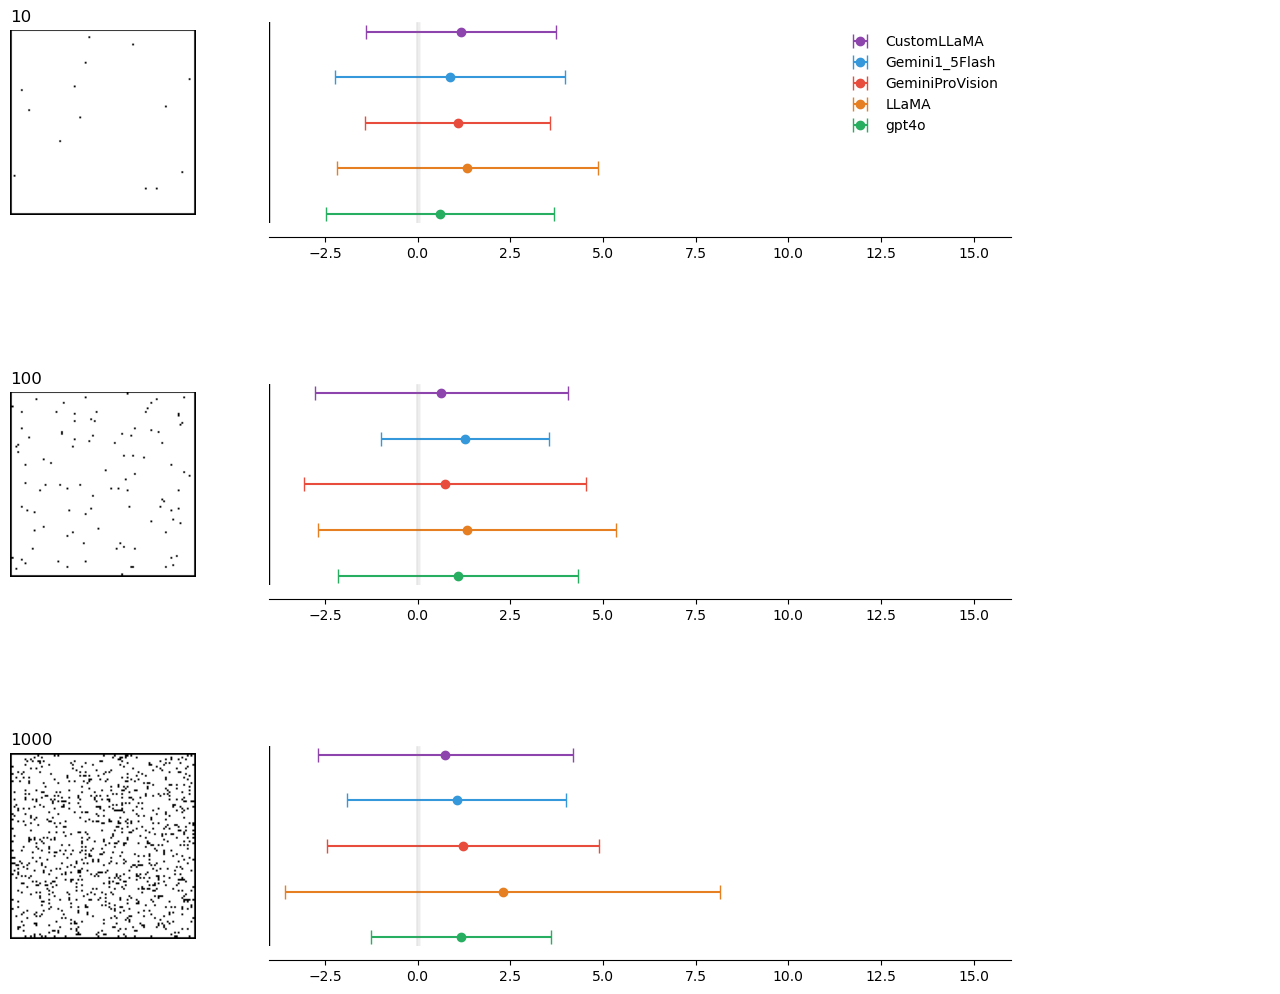

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os

# Example data preparation
# metrics_table is assumed to be prepared and contains columns: 'Dataset', 'Model', 'Average MLAE', 'Std MLAE', 'Confidence Interval (95%)'

# Group data by dataset for easier access
summary_stats_by_task = {df_name: metrics_table[metrics_table['Dataset'] == df_name] for df_name in metrics_table['Dataset'].unique()}

# Define colors for each model
model_colors = {
    'CustomLLaMA': '#8E44AD',       # Purple
    'Gemini1_5Flash': '#3498DB',    # Blue
    'GeminiProVision': '#E74C3C',   # Red
    'LLaMA': '#E67E22',             # Orange
    'gpt4o': '#27AE60'              # Green
}

# Define task images for each dataset (optional)
task_images = {
    'df_10': './10/10_image_1.png',
    'df_100': './100/100_image_1.png',
    'df_1000': './1000/1000_image_1.png'
}


# Plot configuration
num_tasks = len(summary_stats_by_task)
fig, axes = plt.subplots(num_tasks, 3, figsize=(14, 4 * num_tasks), 
                         gridspec_kw={'width_ratios': [1, 4, 1]}, sharex=False)
fig.subplots_adjust(hspace=0.8, left=0.05, right=0.95)
fig.patch.set_facecolor('white')  # Set figure background color to white

# Loop through each task (dataset) and its summary stats
for i, (task_name, task_data) in enumerate(summary_stats_by_task.items()):
    ax_img, ax_plot, ax_label = axes[i]

    # Display task image if available
    if task_name in task_images:
        img_path = task_images[task_name]
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("L")
            img_inverted = ImageOps.invert(img)
            img_with_border = ImageOps.expand(img_inverted.convert("RGB"), border=1, fill="black")
            ax_img.imshow(img_with_border)
            ax_img.set_facecolor("white")
        else:
            ax_img.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=10, color="black")
            ax_img.set_facecolor("white")

    ax_img.axis('off')
    ax_img.set_title(task_name, loc="left", fontsize=12, color="black")

    # Sort model names alphabetically and get y positions
    sorted_model_names = sorted(task_data['Model'].unique())
    y_positions = np.arange(len(sorted_model_names))

    # Plot MLAE and error bars in the middle
    for j, model_name in enumerate(sorted_model_names):
        model_data = task_data[task_data['Model'] == model_name]
        mlae_value = model_data['Average MLAE'].values[0]
        confidence_interval = model_data['Confidence Interval (95%)'].values[0]

        # Plot MLAE with confidence interval error bars
        ax_plot.errorbar(mlae_value, j, xerr=confidence_interval, fmt='o', 
                         color=model_colors.get(model_name, 'gray'), capsize=5, 
                         label=f"{model_name}" if i == 0 else None)

    # Add solid lines for reference points at -4 and -14
    ax_plot.axvline(-4, color="black", linewidth=1)  
    ax_plot.axvline(-14, color="black", linewidth=1)

    ax_plot.grid(False)
    

    # Strip the prefix (like "df_") from task_name to show only numbers
    cleaned_task_name = task_name.replace("df_", "")
    ax_img.set_title(cleaned_task_name, loc="left", fontsize=12, color="black")

    # Add a blurred line at 0 by drawing multiple semi-transparent lines
    for offset in np.linspace(-0.05, 0.05, 10):  # Fine offsets around 0
        ax_plot.axvline(0 + offset, color="gray", alpha=0.1, linewidth=0.5)

    # Customize the middle plot
    ax_plot.spines['top'].set_visible(False)     
    ax_plot.spines['right'].set_visible(False)   
    ax_plot.spines['left'].set_visible(False)    
    ax_plot.spines['bottom'].set_position(('outward', 10)) 

    ax_plot.set_yticks(y_positions)
    ax_plot.set_yticklabels([])  # Hide y-tick labels in the middle
    ax_plot.set_xlim(-4, 16)  
    ax_plot.invert_yaxis()  # Invert y-axis to align with the right labels

    # Display model names on the right
    ax_label.set_yticks(y_positions)
    ax_label.set_yticklabels(sorted_model_names, fontsize=10)
    ax_label.tick_params(left=False, right=False, labelleft=False, labelright=True)
    ax_plot.tick_params(axis='y', which='both', left=False, right=False)  
    ax_label.set_ylim(ax_plot.get_ylim())  
    ax_label.axis("off")

# Add legend to the first row
axes[0, 1].legend(loc="best", frameon=False)

plt.show()

/tmp/ipykernel_1986222/415259907.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data['Model'] = task_data['Model'].replace({'CustomLLaMA': 'Finetuned Llama'})


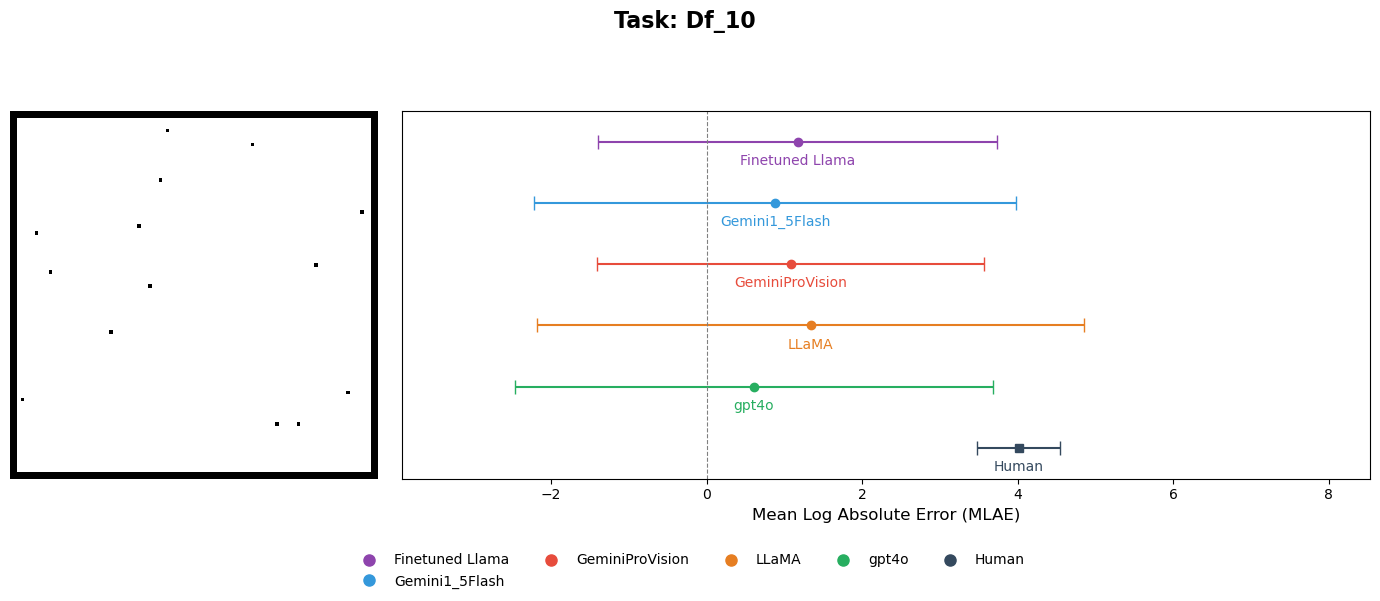

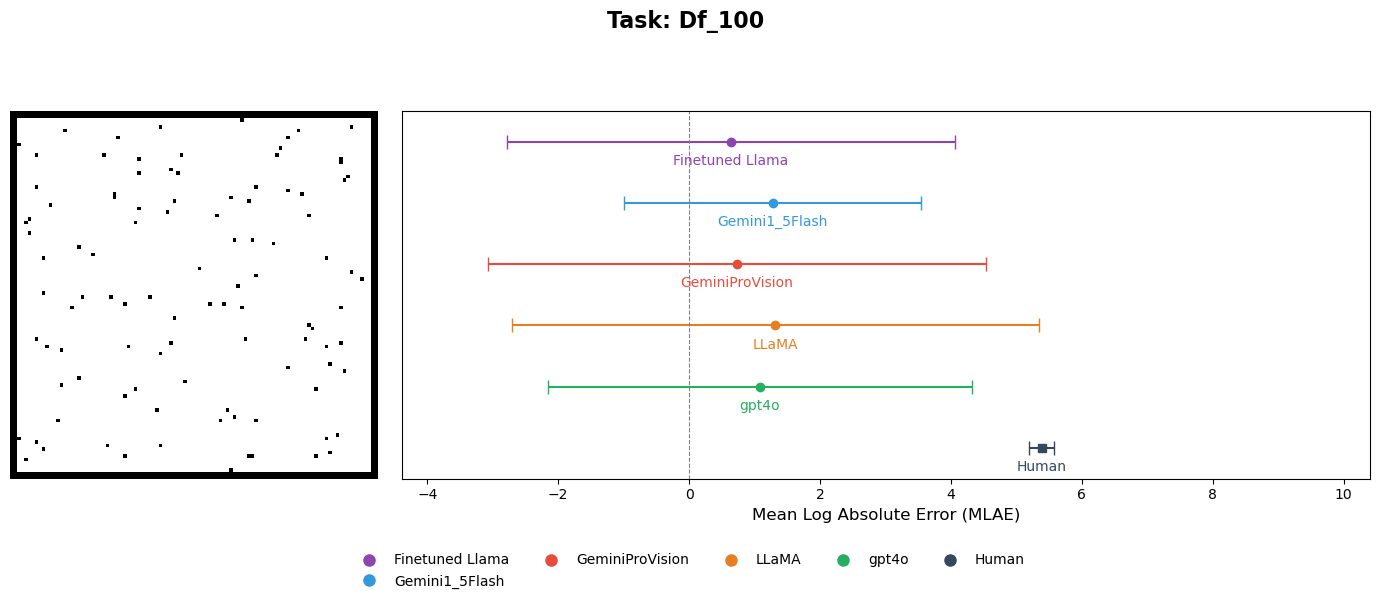

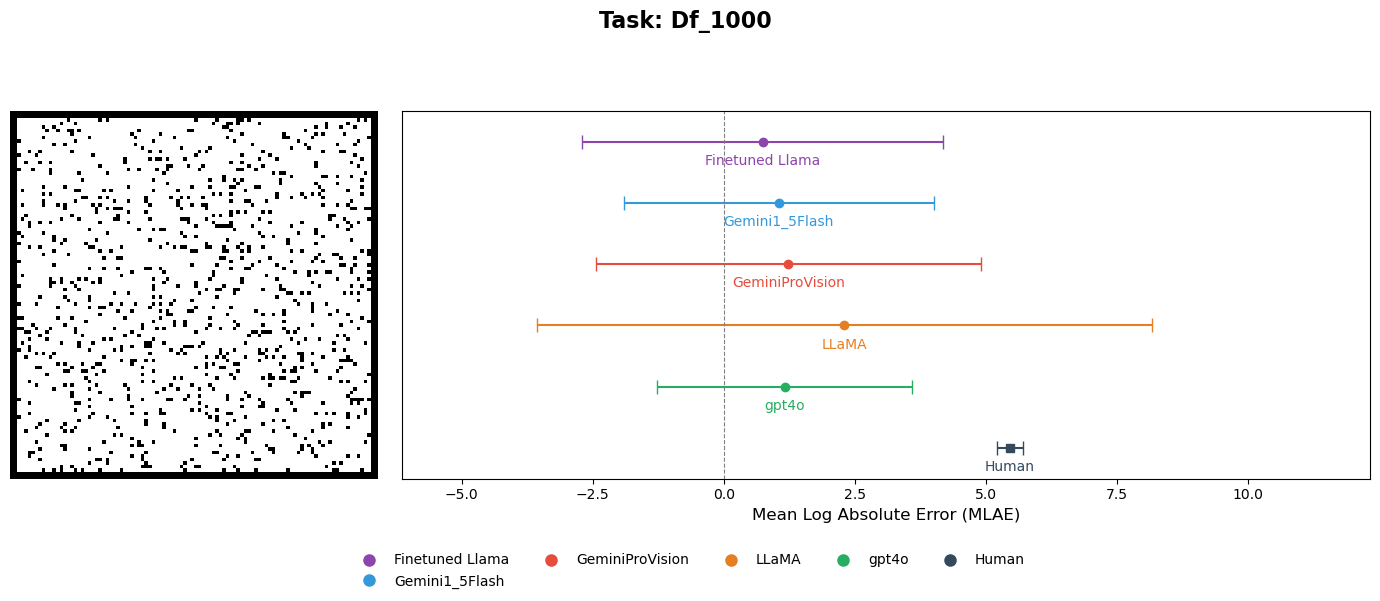

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.lines as mlines

# Example data preparation (Replace this with your actual `metrics_table` data)
summary_stats_by_task = {df_name: metrics_table[metrics_table['Dataset'] == df_name] for df_name in metrics_table['Dataset'].unique()}

# Define the base directory for task images
base_dir = './'

# Define task images for each dataset
task_images = {
    'df_10': os.path.join(base_dir, '10', '10_image_1.png'),
    'df_100': os.path.join(base_dir, '100', '100_image_1.png'),
    'df_1000': os.path.join(base_dir, '1000', '1000_image_1.png')
}

# Define Human benchmark data
human_data = {
    'df_10': (4.0149, 0.5338),
    'df_100': (5.3891, 0.1945),
    'df_1000': (5.4612, 0.2509)
}

# Define colors for models and Human benchmarks
model_colors = {
    'Finetuned Llama': '#8E44AD',   # Purple
    'Gemini1_5Flash': '#3498DB',    # Blue
    'GeminiProVision': '#E74C3C',   # Red
    'LLaMA': '#E67E22',             # Orange
    'gpt4o': '#27AE60',             # Green
    'Human': '#34495E'              # Dark Gray
}

def plot_single_task(task_name, task_data):
    """
    Plot MLAE with error bars and corresponding task image for a single task.
    """
    fig, (ax_img, ax_plot) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 5]})
    fig.patch.set_facecolor('white')
    fig.suptitle(f"Task: {task_name.capitalize()}", fontsize=16, color="black", fontweight='bold')

    # Display task image
    img_path = task_images.get(task_name)
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path).convert("L")
        img_inverted = ImageOps.invert(img)
        img_with_border = ImageOps.expand(img_inverted.convert("RGB"), border=2, fill="black")
        ax_img.imshow(img_with_border)
        ax_img.axis('off')
    else:
        ax_img.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=12, color="black")
        ax_img.set_facecolor("white")

    # Replace "CustomLLaMA" with "Finetuned Llama" in the task data
    task_data['Model'] = task_data['Model'].replace({'CustomLLaMA': 'Finetuned Llama'})

    # Sort models and set up y positions
    sorted_model_names = sorted(task_data['Model'].unique())
    y_positions = np.arange(len(sorted_model_names) + 1)  # +1 for Human

    # Plot MLAE and error bars for each model
    for j, model_name in enumerate(sorted_model_names):
        model_data = task_data[task_data['Model'] == model_name]
        mlae_value = model_data['Average MLAE'].values[0]
        confidence_interval = model_data['Confidence Interval (95%)'].values[0]

        ax_plot.errorbar(mlae_value, j, xerr=confidence_interval, fmt='o',
                         color=model_colors.get(model_name, 'gray'), capsize=5)

        # Label each point with the model name
        ax_plot.text(mlae_value, j + 0.2, model_name, horizontalalignment='center',
                     verticalalignment='top', color=model_colors.get(model_name, 'gray'), fontsize=10)

    # Add Human MLAE if available
    if task_name in human_data:
        human_mlae, human_error = human_data[task_name]
        ax_plot.errorbar(human_mlae, len(sorted_model_names), xerr=human_error, fmt='s',
                         color=model_colors['Human'], capsize=5, label="Human")
        ax_plot.text(human_mlae, len(sorted_model_names) + 0.2, "Human", horizontalalignment='center',
                     verticalalignment='top', color=model_colors['Human'], fontsize=10)

    # Dynamically set x-axis limits
    all_mlae = list(task_data['Average MLAE']) + ([human_data[task_name][0]] if task_name in human_data else [])
    all_confidence = list(task_data['Confidence Interval (95%)'])
    max_limit = max(all_mlae) + max(all_confidence)
    min_limit = min(all_mlae) - max(all_confidence)
    ax_plot.set_xlim(min_limit - 1, max_limit + 1)

    # Customize plot
    ax_plot.axvline(0, color="gray", linestyle="--", linewidth=0.8)
    ax_plot.set_ylim(-0.5, len(sorted_model_names) + 0.5)
    ax_plot.invert_yaxis()
    ax_plot.set_yticks([])
    ax_plot.set_xlabel("Mean Log Absolute Error (MLAE)", fontsize=12)

    # Add legend
    custom_legend = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=8, label=name)
                     for name, color in model_colors.items()]
    fig.legend(handles=custom_legend, loc='lower center', ncol=5, frameon=False, fontsize=10)

    plt.tight_layout(rect=[0, 0.1, 1, 0.9])
    plt.show()

# Loop through each task and plot MLAE for that specific task
for task_name, task_data in summary_stats_by_task.items():
    plot_single_task(task_name, task_data)


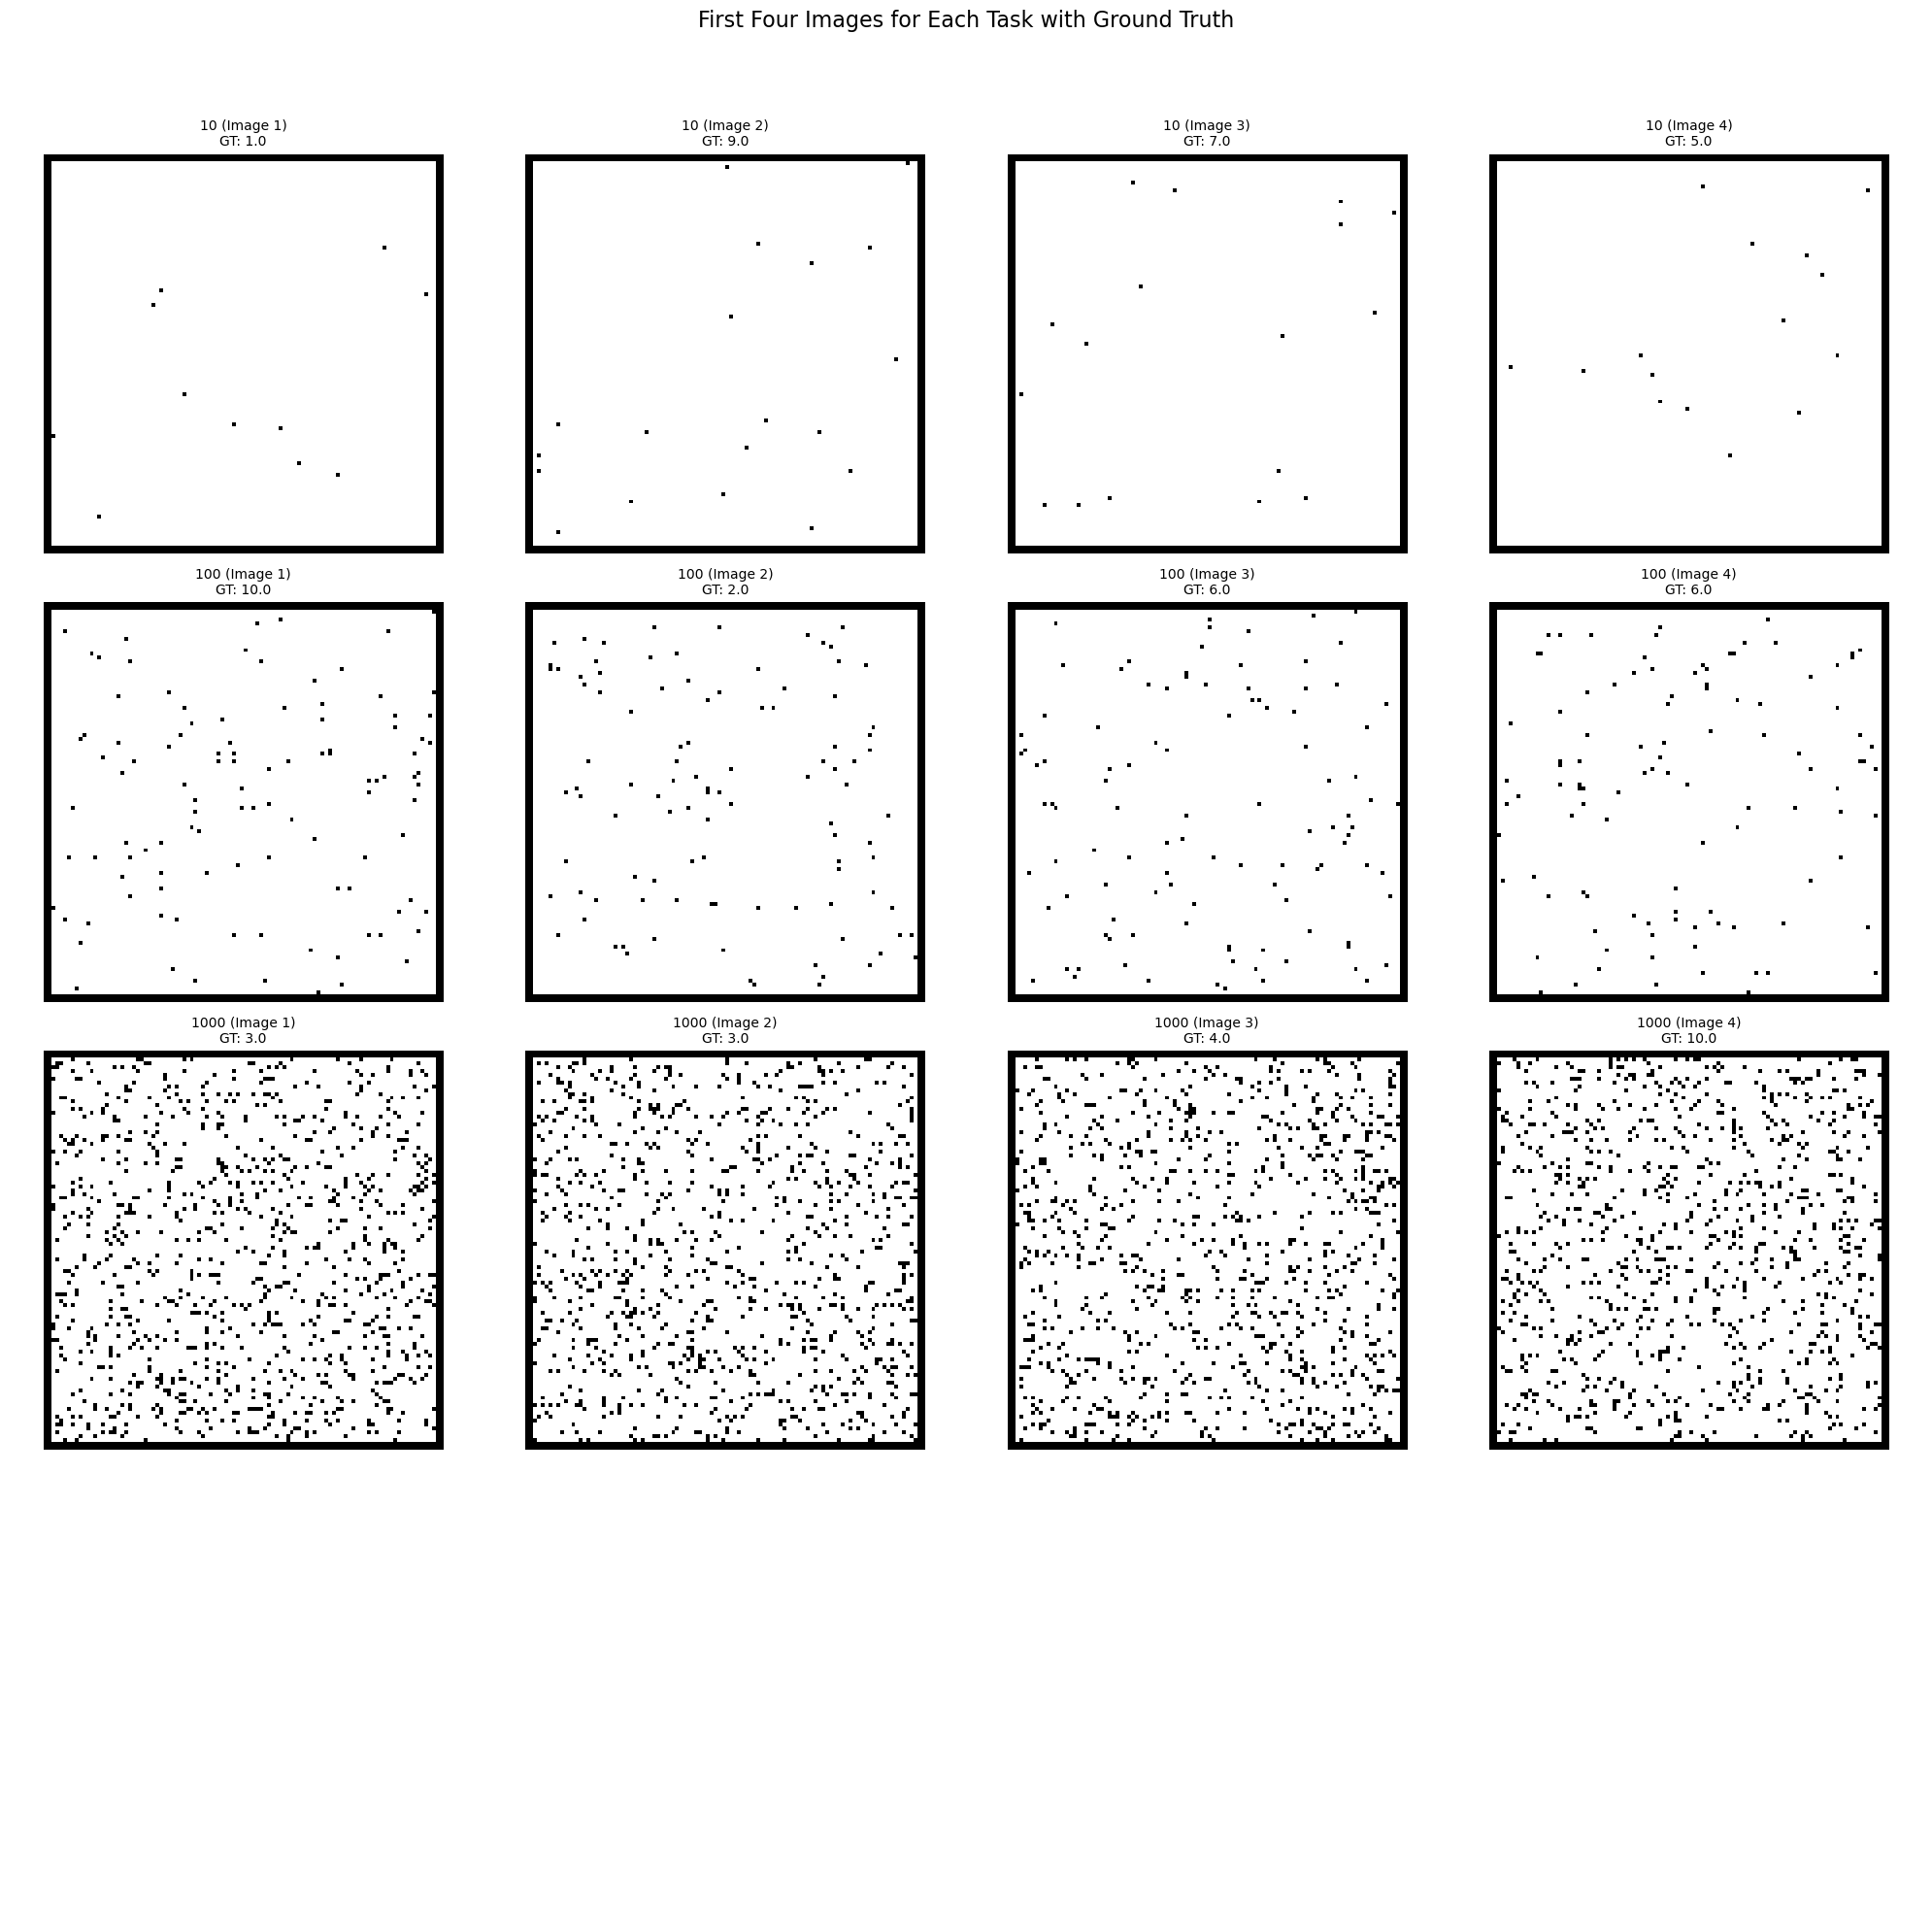

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Define the base folder where images are located
base_folder = "." 

# List of CSV files representing different tasks
csv_files = [
    './10_results.csv',
    './100_results.csv',
    './1000_results.csv'
]

# Number of columns and rows for the plot grid
num_cols = 4
num_rows = 4  # Adjusted grid size for displaying images

# Create a figure with subplots for displaying images in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
fig.suptitle("First Four Images for Each Task with Ground Truth", fontsize=16)

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

# Initialize subplot index
subplot_idx = 0

# Loop through each CSV file and display the first four images for each task
for csv_file in csv_files:
    # Check if CSV file exists
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        continue

    # Read the CSV file
    results_df = pd.read_csv(csv_file)

    # Extract the task name from the CSV filename (e.g., '10' from '10_results.csv')
    task = os.path.basename(csv_file).replace('_results.csv', '')

    # Loop through the first four rows to display images
    for i in range(4):  # Get the first four images
        if subplot_idx >= num_rows * num_cols:
            print("No more subplots available.")
            break

        if i >= len(results_df):
            print(f"Not enough images in {csv_file} to display four images.")
            break
        
        row = results_df.iloc[i]
        
        # Use the full image path from the "image_path" column
        image_filename = os.path.basename(row["image_path"])
        image_path = os.path.join(base_folder, task, image_filename)
        ground_truth = row["ground_truth"]

        if os.path.exists(image_path):
            # Open and process the image
            img = Image.open(image_path)
            img_array = np.array(img)
            
            # Find the boundaries of the white background
            rows = np.any(img_array < 255, axis=1)
            cols = np.any(img_array < 255, axis=0)
            ymin, ymax = np.where(rows)[0][[0, -1]]
            xmin, xmax = np.where(cols)[0][[0, -1]]
            
            # Add a small padding
            padding = 10
            ymin = max(0, ymin - padding)
            ymax = min(img_array.shape[0], ymax + padding)
            xmin = max(0, xmin - padding)
            xmax = min(img_array.shape[1], xmax + padding)
            
            # Crop the image
            img_array = img_array[ymin:ymax, xmin:xmax]
            
            # Invert the colors
            img_array = 255 - img_array
            
            # Convert back to PIL Image for easier manipulation
            img_cropped = Image.fromarray(img_array)
            
            # Add a black border around each cropped image
            border_size = 2  # Adjust border thickness as needed
            img_with_border = ImageOps.expand(img_cropped, border=border_size, fill='black')

            # Display the processed image with border
            axes[subplot_idx].imshow(img_with_border, cmap="gray")
            # Round ground_truth to two decimal places if it’s numeric
            ground_truth = round(ground_truth, 2) if isinstance(ground_truth, (int, float)) else ground_truth
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nGT: {ground_truth}", fontsize=10)
        else:
            print(f"Image not found: {image_path}")
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nImage not found", fontsize=10)

        # Add a black border around each subplot
        for spine in axes[subplot_idx].spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

        # Remove axis ticks
        axes[subplot_idx].axis("off")
        
        # Move to the next subplot
        subplot_idx += 1

# Hide any remaining empty subplots
for j in range(subplot_idx, num_rows * num_cols):
    axes[j].axis("off")

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout and title spacing
plt.show()
